In [1]:
#https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%201%20-%20Lesson%203%20-%20Notebook.ipynb#scrollTo=iN2MsBxWTE3m
!pip install tensorflow==2.0.0.b1

    100% |████████████████████████████████| 87.9MB 422kB/s eta 0:00:01
    100% |████████████████████████████████| 501kB 19.2MB/s ta 0:00:01
    100% |████████████████████████████████| 3.1MB 6.9MB/s eta 0:00:01
tb-nightly 1.14.0a20190603 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
  Found existing installation: tensorflow 1.8.0
    Uninstalling tensorflow-1.8.0:
      Successfully uninstalled tensorflow-1.8.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

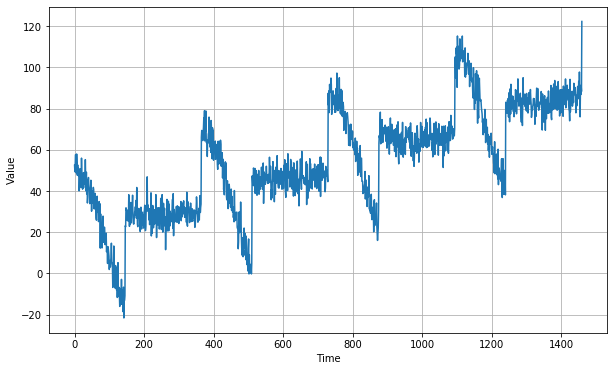

In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, 
                   np.cos(season_time * 2 * np.pi),
                   1/np.exp(3*season_time)
                   )

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4*365+1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

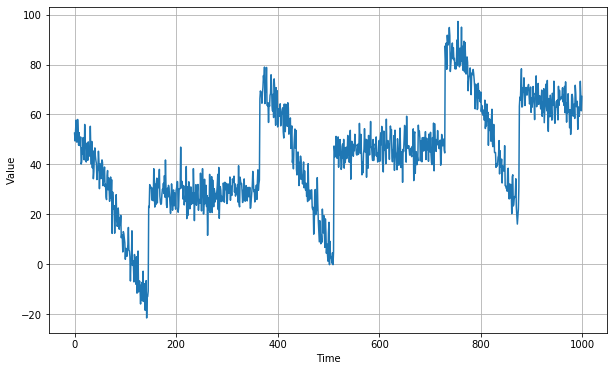

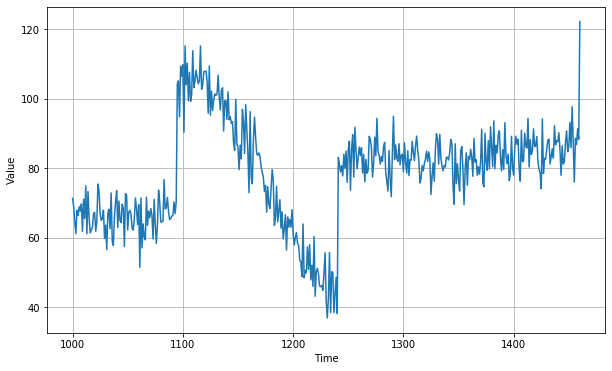

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10,6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [12]:
naive_forecast = series[split_time-1:-1]

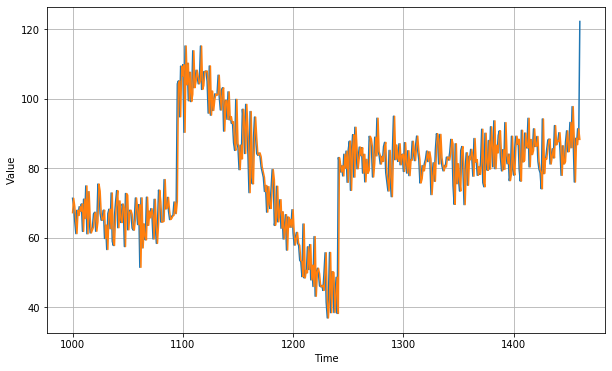

In [13]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

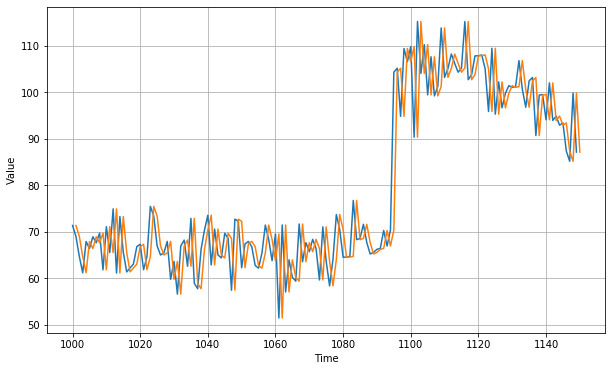

In [14]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [15]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.937908


# Now Let's try a moving average:

In [20]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time+window_size].mean())
    return np.array(forecast)

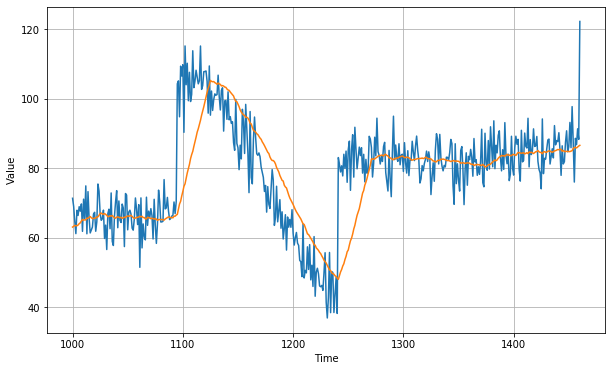

In [21]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [22]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


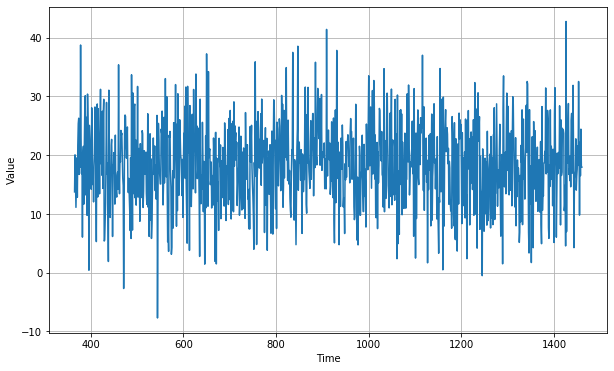

In [24]:
## The moving average does not anticipate trend or seasonality, so try to remove them by using differencing. 
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

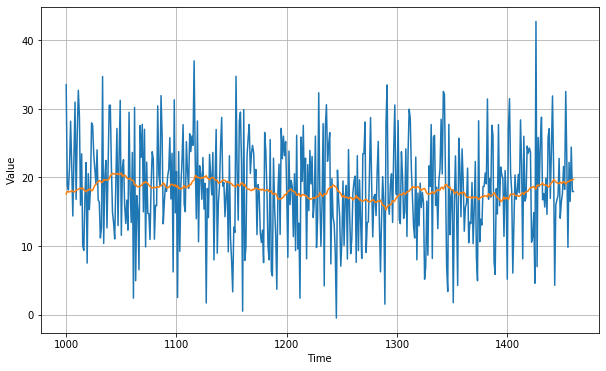

In [25]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time-365-50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

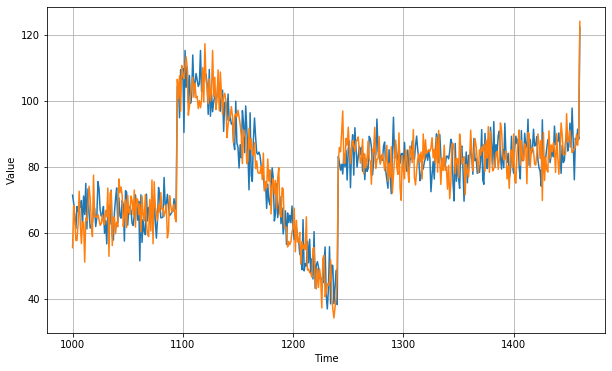

In [26]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [27]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


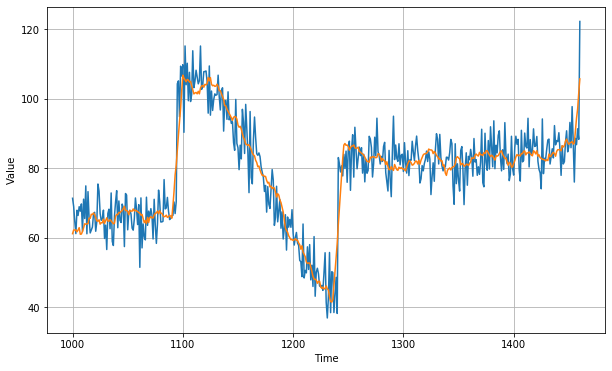

In [28]:
## The forecast look spiky, because we're adding random past values. 
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time-370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [29]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442


In [30]:
# Neural Nets